### 1. Load dataset

In [1]:
dataset_base_path = r'/Users/kripik123/Documents/dataset/processedx/selected_fiture_per-dataset/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import describe
from collections import Counter
from IPython.display import display
from time import time #time stamp for all processing time

%matplotlib inline

In [2]:
types = {
    'protocol': 'uint8',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_mean': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_std': 'float32',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_pkts_s': 'float32',
    'fin_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'idle_mean': 'float32',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 2. Preprocessing Data

In [3]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, 'dos-*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [4]:
## bagi dataset menjadi 80 % untuk training, 10 % untuk testing, 10% untuk evaluasi
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

##X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
##X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
##X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [5]:
## hitung jumlah sampel per kategori di dataset
y.label.value_counts()

Benign                      1442849
DoS attacks-Hulk             461912
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
Name: label, dtype: int64

In [6]:
## hitung persentasi antara sampel attack dengan benign

percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    1154279
1     523440
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.6880


## 3. Classifier

In [7]:
## 0 fungsi print report terdiri dari precision score, confusion matrix, f1 score, recall score

from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

#### algoritma yang dipake sesuai Paper Qianru Zhou 
- Random forest
- Gaussian naïve bayes
- Decision tree
- MLP
- K-nn
- Quadratic discriminant analysis

In [10]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_dummy, X_train, y_train.label_is_attack, cls_dummy.predict(X_train))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report (Train):


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    796862
           1       0.00      0.00      0.00     41998

    accuracy                           0.95    838860
   macro avg       0.47      0.50      0.49    838860
weighted avg       0.90      0.95      0.93    838860

Avg Precision Score: 0.05006556517178075


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     99607
           1       0.00      0.00      0.00      5250

    accuracy                           0.95    104857
   macro avg       0.47      0.50      0.49    104857
weighted avg       0.90      0.95      0.93    104857

Avg Precision Score: 0.050068188103798504


Time to fit Data Train
0:00:00.04


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    796862
           1       0.99      1.00      1.00     41998

    accuracy                           1.00    838860
   macro avg       1.00      1.00      1.00    838860
weighted avg       1.00      1.00      1.00    838860

Avg Precision Score: 0.9922212809713225




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Classification Report (Eval):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99607
           1       0.99      1.00      1.00      5250

    accuracy                           1.00    104857
   macro avg       1.00      1.00      1.00    104857
weighted avg       1.00      1.00      1.00    104857

Avg Precision Score: 0.9913463525291096


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


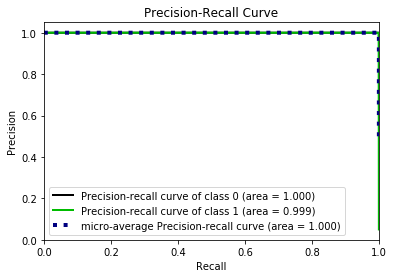



Time to fit Data Train
0:00:32.85


In [8]:
## 2. RandomForest form scikit-learn with default value
start_time = time()
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
cls_forest.fit(X_train_oh, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_forest, X_train_oh, y_train.label_is_attack, cls_forest.predict(X_train_oh))
print_report('Eval', cls_forest, X_eval_oh, y_eval.label_is_attack, cls_forest.predict(X_eval_oh), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


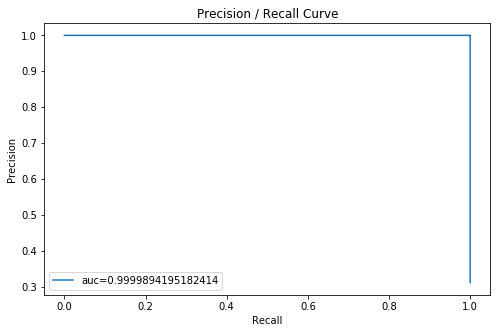

Average PR Score 0.9999894195182414


In [7]:
## coba dari source code binary classification

from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve, plot_pr_curves, plot_pr_threshold_curves
from ml_ids.prediction import predict_proba_positive, predict_decision_boundary

cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
cls_forest.fit(X_train, y_train.label_is_attack)

pred_val_proba_rf = predict_proba_positive(cls_forest, X_eval)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_rf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    144285
           1      1.000     1.000     1.000     65430

    accuracy                          1.000    209715
   macro avg      1.000     1.000     1.000    209715
weighted avg      1.000     1.000     1.000    209715

Confusion Matrix:


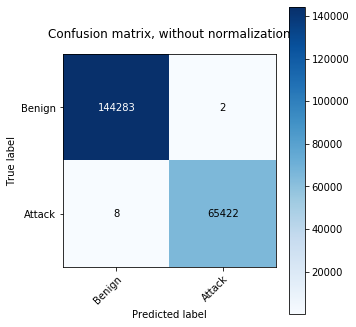

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,8,1099,0.007279
Benign,2,144285,0.000014


In [14]:
pred_val_rf = cls_forest.predict(X_eval)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_rf)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
## 3. Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

start_time = time()
cls_nb = GaussianNB()
cls_nb.fit(X_train, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
##print_report('Train', cls_nb, X_train, y_train.label_is_attack, cls_nb.predict(X_train))
##print_report('Eval', cls_nb, X_eval, y_eval.label_is_attack, cls_nb.predict(X_eval))
print_report('Train', cls_nb, scaler.transform(X_train), y_train.label_is_attack, cls_nb.predict(scaler.transform(X_train)))
print_report('Eval', cls_nb, scaler.transform(X_eval), y_eval.label_is_attack, cls_nb.predict(scaler.transform(X_eval)), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

NameError: name 'print_report' is not defined

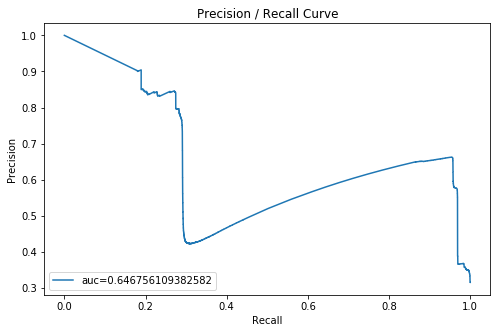

Average PR Score 0.646756109382582


In [12]:
## coba dari source code binary classification

cls_nb = GaussianNB()
cls_nb.fit(X_train, y_train.label_is_attack)

pred_val_proba_nb = predict_proba_positive(cls_nb, X_eval)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_nb)

Classification Report:
              precision    recall  f1-score   support

           0      0.972     0.191     0.319    144285
           1      0.356     0.988     0.524     65430

    accuracy                          0.439    209715
   macro avg      0.664     0.589     0.421    209715
weighted avg      0.780     0.439     0.383    209715

Confusion Matrix:


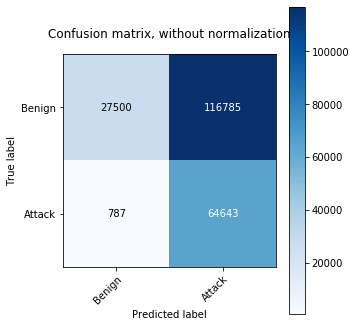

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Benign,116785,144285,0.809405
DoS attacks-GoldenEye,608,4151,0.146471
DoS attacks-Slowloris,44,1099,0.040036
DoS attacks-Hulk,135,46191,0.002923


In [13]:
pred_val_nb = cls_nb.predict(X_eval)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_nb)

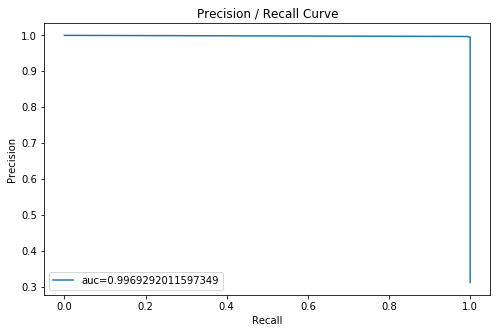

Average PR Score 0.9969292011597349


In [15]:
## 4. Decission Tree
from sklearn.tree import DecisionTreeClassifier

cls_dt = DecisionTreeClassifier(max_depth=5,criterion="entropy")
cls_dt.fit(X_train, y_train.label_is_attack)

pred_val_proba_dt = predict_proba_positive(cls_dt, X_eval)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_dt)

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.998     0.999    144285
           1      0.995     1.000     0.997     65430

    accuracy                          0.998    209715
   macro avg      0.997     0.999     0.998    209715
weighted avg      0.998     0.998     0.998    209715

Confusion Matrix:


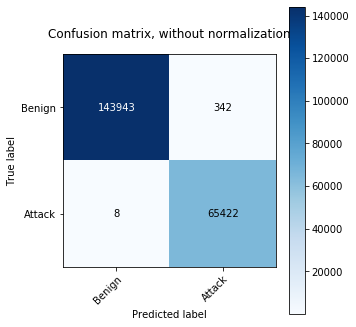

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,8,1099,0.007279
Benign,342,144285,0.002370


In [16]:
pred_val_dt = cls_dt.predict(X_eval)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_dt)

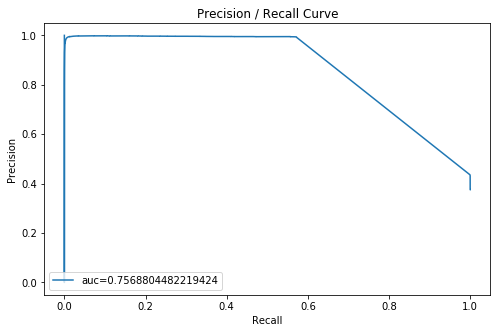

Average PR Score 0.7568804482219424


In [18]:
## 5. MLP
from sklearn.neural_network import MLPClassifier

cls_mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
cls_mlp.fit(X_train, y_train.label_is_attack)

pred_val_proba_mlp = predict_proba_positive(cls_mlp, X_eval)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_mlp)

Classification Report:
              precision    recall  f1-score   support

           0      0.838     0.997     0.911    144285
           1      0.990     0.573     0.726     65430

    accuracy                          0.865    209715
   macro avg      0.914     0.785     0.818    209715
weighted avg      0.885     0.865     0.853    209715

Confusion Matrix:


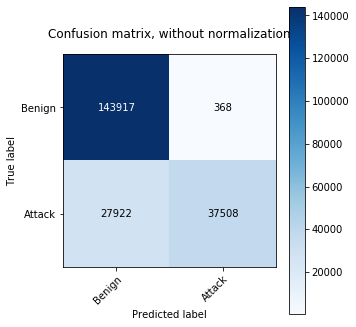

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-SlowHTTPTest,13989,13989,1.000000
DoS attacks-Slowloris,1099,1099,1.000000
DoS attacks-GoldenEye,4150,4151,0.999759
DoS attacks-Hulk,8684,46191,0.188002
Benign,368,144285,0.002551


In [19]:
pred_val_mlp = cls_mlp.predict(X_eval)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_mlp)

In [ ]:
## 6. KNN
from sklearn.neighbors import KNeighborsClassifier

start_time = time()
cls_knn = KNeighborsClassifier(3)

In [ ]:
## 7. QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

start_time = time()
cls_qda = QDA()

### algoritma lainnya misalnya Log regresion --> tapi algor ini belum ada di paper IDS manapun
- Gozde Karatas (Knn, Random Forest, Gradient Boosting, Adaboost, Decision Tree, LDA)

In [ ]:
## 3. Log Regression from scikit-learn with default value
start_time = time()
cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_lr, scaler.transform(X_train_oh), y_train.label_is_attack, cls_lr.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_lr, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_lr.predict(scaler.transform(X_eval_oh)), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [ ]:
## 5. Gradient Boosting form CatBoost --> opensource 
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [ ]:
start_time = time()
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)
end_time=time()
total=end_time-start_time

In [ ]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|z|0.00|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.